In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# -----------------------------
# Repro & Config
# -----------------------------
np.random.seed(42)
tf.random.set_seed(42)
CLASS_NAMES = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


In [3]:
# -----------------------------
# Data
# -----------------------------

def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)
    return (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat)


In [4]:
# -----------------------------
# SqueezeNet Fire Module (minimal)
# -----------------------------

def fire_module(x, s1x1, e1x1, e3x3, name="fire"):
    """SqueezeNet Fire block: squeeze 1x1 → expand (1x1, 3x3), ReLU activations as in paper.
    We keep spatial size and concatenate expand outputs along channels.
    """
    with tf.name_scope(name):
        squeeze = layers.Conv2D(s1x1, 1, activation='relu', padding='same', name=f"{name}_squeeze1x1")(x)
        expand1x1 = layers.Conv2D(e1x1, 1, activation='relu', padding='same', name=f"{name}_expand1x1")(squeeze)
        expand3x3 = layers.Conv2D(e3x3, 3, activation='relu', padding='same', name=f"{name}_expand3x3")(squeeze)
        out = layers.Concatenate(name=f"{name}_concat")([expand1x1, expand3x3])
        return out

In [5]:
# -----------------------------
# Model (one Fire block, late downsample)
# -----------------------------

def build_squeezenet_one_block():
    inputs = layers.Input(shape=(32, 32, 3))

    # Stem conv (stride 1 to delay downsampling, per paper strategy)
    x = layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', name='conv1')(inputs)

    # One Fire block (modest channels to keep training lightweight)
    x = fire_module(x, s1x1=16, e1x1=32, e3x3=32, name='fire2')

    # Late downsample to aggregate features (max pool after Fire)
    x = layers.MaxPooling2D(pool_size=2, name='maxpool_fire')(x)

    # Head: GAP → softmax (fully conv classifier style)
    x = layers.GlobalAveragePooling2D(name='gap')(x)
    outputs = layers.Dense(10, activation='softmax', name='probs')(x)

    model = models.Model(inputs, outputs, name='squeezenet_one_fire')
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [6]:
# -----------------------------
# Training + Visualizations
# -----------------------------

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epochs'); plt.legend(); plt.grid(True)
    plt.show()


In [7]:
def plot_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
    plt.tight_layout(); plt.show()


In [8]:
def show_sample_predictions(x, y_true, y_pred, class_names, n=12):
    idxs = np.random.choice(len(x), size=n, replace=False)
    cols = 6
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(2.1*cols, 2.4*rows))
    for i, idx in enumerate(idxs):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(x[idx])
        t = class_names[int(y_true[idx])]
        p = class_names[int(y_pred[idx])]
        ax.set_title(f"T:{t}\nP:{p}", fontsize=9)
        ax.axis('off')
    plt.suptitle('Random Test Samples: True vs Predicted', y=1.02)
    plt.tight_layout(); plt.show()


In [9]:
def summarize_params(model):
    total = model.count_params()
    params_1x1 = 0
    params_3x3 = 0
    for l in model.layers:
        if isinstance(l, layers.Conv2D):
            k = l.kernel_size
            if k == (1,1):
                params_1x1 += l.count_params()
            elif k == (3,3):
                params_3x3 += l.count_params()
    print("\nParameter Breakdown:")
    print(f"Total params: {total:,}")
    print(f"1x1 conv params: {params_1x1:,}")
    print(f"3x3 conv params: {params_3x3:,}")


In [10]:
# -----------------------------
# Grad-CAM (use expand 3x3 conv from the Fire block)
# -----------------------------

def grad_cam(model, images, class_indices=None, expand3x3_layer_name='fire2_expand3x3', overlay=True):
    last_conv = model.get_layer(expand3x3_layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [last_conv.output, model.output])

    heatmaps = []
    preds = model.predict(images, verbose=0)
    if class_indices is None:
        class_indices = np.argmax(preds, axis=1)

    for i in range(len(images)):
        img = images[i:i+1]
        class_idx = int(class_indices[i])
        with tf.GradientTape() as tape:
            conv_out, preds_out = grad_model(img)
            loss = preds_out[:, class_idx]
        grads = tape.gradient(loss, conv_out)  # (1, h, w, c)
        pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
        conv_out = conv_out[0]
        heatmap = tf.reduce_sum(tf.multiply(conv_out, pooled_grads), axis=-1)
        heatmap = tf.nn.relu(heatmap)
        heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
        heatmaps.append(heatmap.numpy())

    # Plot a few
    n = min(6, len(images))
    plt.figure(figsize=(12, 6))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f"Image {i+1}")

        plt.subplot(2, n, n+i+1)
        hm = heatmaps[i]
        hm = np.uint8(255 * hm)
        hm = np.stack([hm]*3, axis=-1)
        hm = tf.image.resize(tf.cast(hm, tf.float32), [images[i].shape[0], images[i].shape[1]]).numpy().astype(np.uint8)
        if overlay:
            over = (0.6*images[i] + 0.4*(hm/255.0)).clip(0,1)
            plt.imshow(over)
        else:
            plt.imshow(hm)
        plt.axis('off')
        plt.title('Grad-CAM')
    plt.tight_layout(); plt.show()


In [11]:
# -----------------------------
# Inspect 3x3 kernels & Fire feature maps
# -----------------------------

def visualize_expand3x3_kernels(model, layer_name='fire2_expand3x3', max_out=8):
    layer = model.get_layer(layer_name)
    weights = layer.get_weights()
    if not weights:
        print("Layer weights not initialized yet.")
        return
    kernel = weights[0]  # (3,3,in,out)
    out_ch = min(max_out, kernel.shape[-1])
    plt.figure(figsize=(2*out_ch, 2))
    for i in range(out_ch):
        ax = plt.subplot(1, out_ch, i+1)
        k2d = kernel[:,:,0,i]  # visualize first input channel slice
        ax.imshow(k2d, cmap='coolwarm')
        ax.set_title(f"F{i}")
        ax.axis('off')
    plt.suptitle('Expand 3x3 Kernels (slice per filter)')
    plt.tight_layout(); plt.show()



In [12]:
def visualize_fire_feature_maps(model, x_sample, layer_name='fire2_concat', max_maps=8):
    layer = model.get_layer(layer_name)
    fmap_model = tf.keras.Model(inputs=model.inputs, outputs=layer.output)
    fmap = fmap_model.predict(x_sample[None, ...], verbose=0)[0]  # (H,W,C)
    c = min(max_maps, fmap.shape[-1])
    plt.figure(figsize=(2*c, 2.4))
    for i in range(c):
        ax = plt.subplot(1, c, i+1)
        ax.imshow(fmap[:,:,i], cmap='viridis')
        ax.axis('off')
        ax.set_title(f"FM {i}")
    plt.suptitle('Fire Block Feature Maps (subset)')
    plt.tight_layout(); plt.show()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "squeezenet_one_fire"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_squeeze1x1    │ (None, 32, 32,    │        528 │ conv1[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand1x1     │ (None, 32, 32,    │        544 │ fire2_squeeze1x1… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_expand3x3     │ (None, 32, 32,    │      4,640 │ fire2_squeeze1x1… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire2_concat        │ (None, 32, 32,    │          0 │ fire2_expand1x1[… │
│ (Concatenate)       │ 64)               │            │ fire2_expand3x3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool_fire        │ (None, 16, 16,    │          0 │ fire2_concat[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 64)        │          0 │ maxpool_fire[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ probs (Dense)       │ (None, 10)        │        650 │ gap[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,258 (28.35 KB)

 Trainable params: 7,258 (28.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1699 - loss: 2.1880 - val_accuracy: 0.2253 - val_loss: 2.0177
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2606 - loss: 1.9758 - val_accuracy: 0.2852 - val_loss: 1.9167
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.2943 - loss: 1.8854 - val_accuracy: 0.3206 - val_loss: 1.8418
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3247 - loss: 1.8184 - val_accuracy: 0.3484 - val_loss: 1.7624
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3503 - loss: 1.7527 - val_accuracy: 0.3712 - val_loss: 1.7116


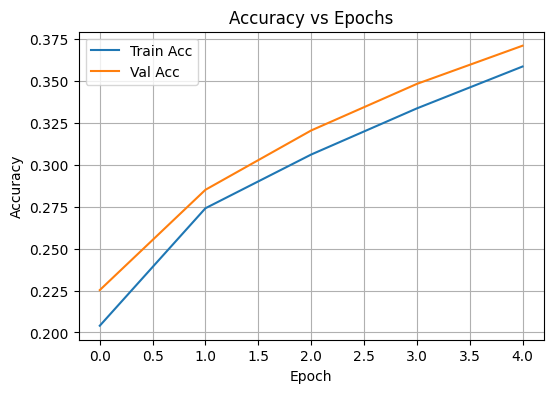

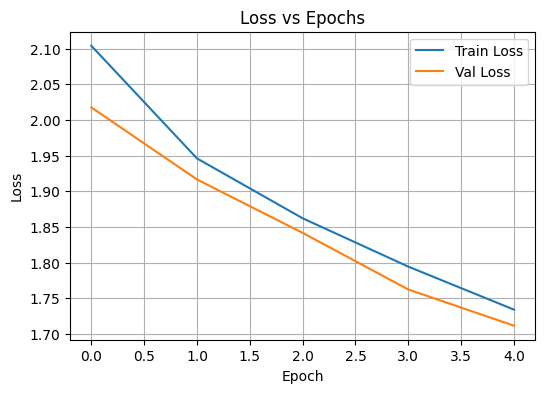


Test Accuracy: 0.3747

Classification Report:

              precision    recall  f1-score   support

    airplane       0.48      0.36      0.41      1000
  automobile       0.43      0.62      0.51      1000
        bird       0.28      0.28      0.28      1000
         cat       0.29      0.10      0.15      1000
        deer       0.46      0.14      0.22      1000
         dog       0.39      0.33      0.36      1000
        frog       0.30      0.61      0.41      1000
       horse       0.36      0.27      0.30      1000
        ship       0.42      0.71      0.53      1000
       truck       0.38      0.34      0.36      1000

    accuracy                           0.37     10000
   macro avg       0.38      0.37      0.35     10000
weighted avg       0.38      0.37      0.35     10000



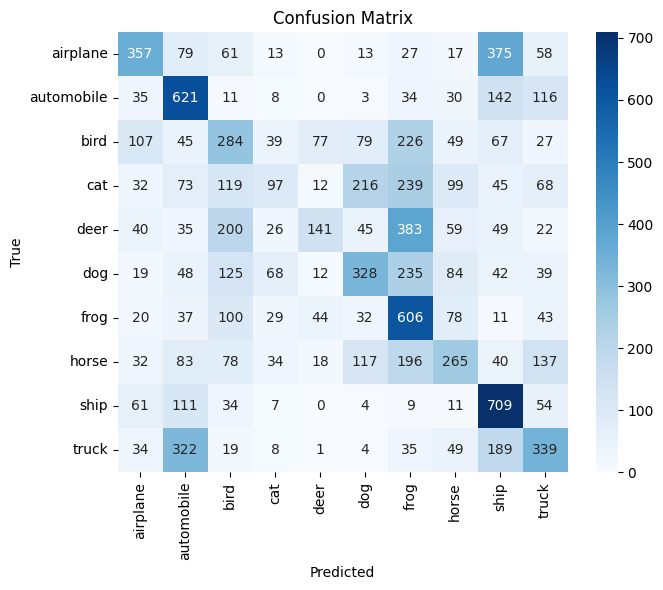

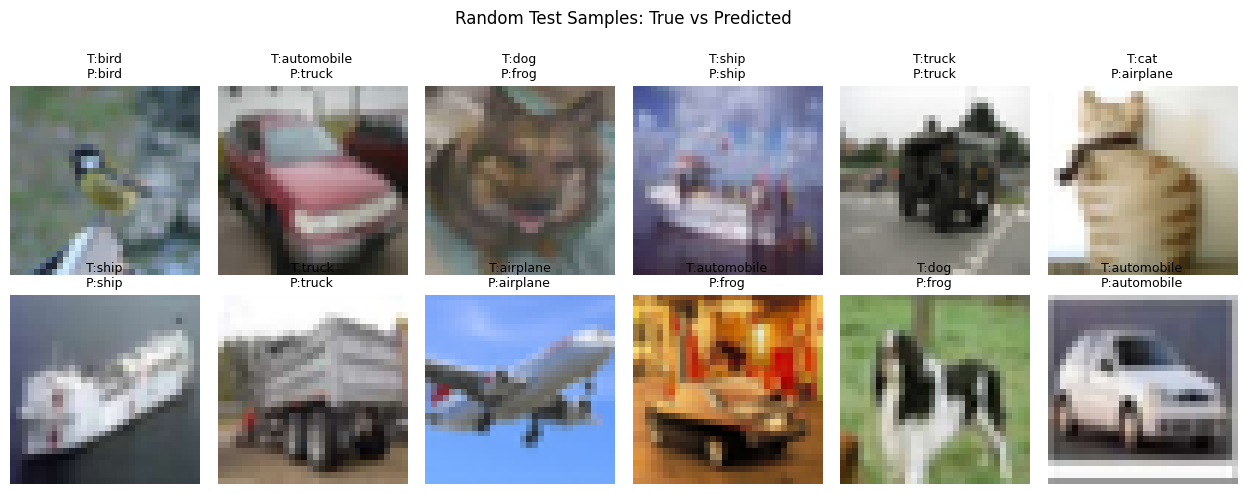


Parameter Breakdown:
Total params: 7,258
1x1 conv params: 1,072
3x3 conv params: 5,536


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


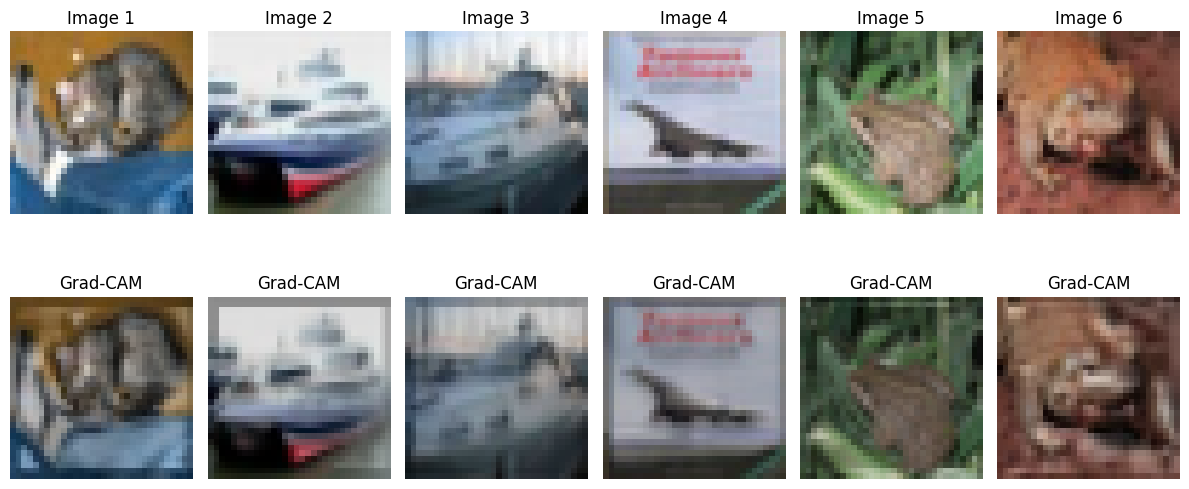

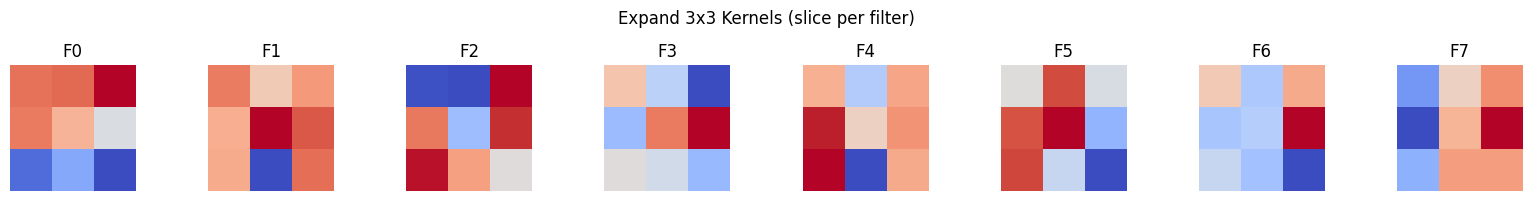

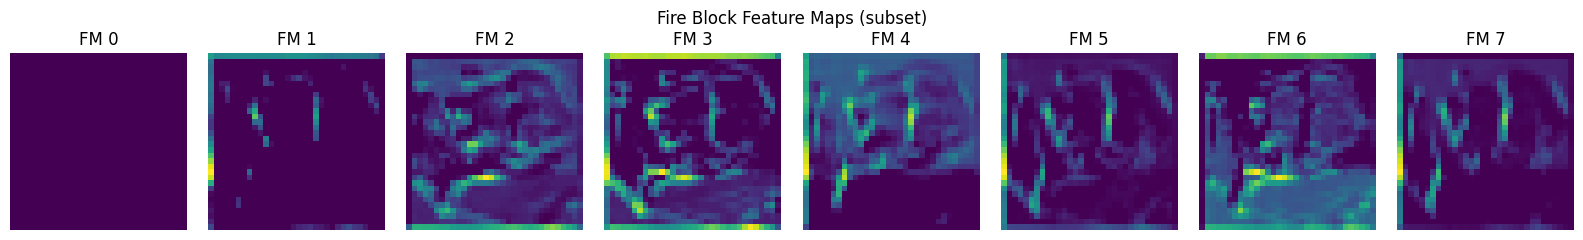

In [13]:
# -----------------------------
# Run end-to-end (5 epochs)
# -----------------------------

if __name__ == "__main__":
    (x_train, y_train, y_train_cat), (x_test, y_test, y_test_cat) = load_data()

    model = build_squeezenet_one_block()
    model.summary()

    history = model.fit(
        x_train, y_train_cat,
        validation_split=0.2,
        epochs=5,
        batch_size=128,
        verbose=1
    )

    plot_history(history)

    # Evaluate & predictions
    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
    print(f"\nTest Accuracy: {test_acc:.4f}")

    y_probs = model.predict(x_test, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = y_test.flatten()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    plot_confusion(y_true, y_pred, CLASS_NAMES)
    show_sample_predictions(x_test, y_true, y_pred, CLASS_NAMES, n=12)

    summarize_params(model)

    # Grad-CAM on a handful of test images (uses expand 3x3 layer)
    grad_cam(model, x_test[:6])

    # Inspect kernels & feature maps
    visualize_expand3x3_kernels(model, max_out=8)
    visualize_fire_feature_maps(model, x_test[0], max_maps=8)


In [14]:
# ==== TensorBoard + Evaluations (drop-in) ======================================
import os, io, itertools
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Optional: make a fixed validation split (works better for per-epoch logging)
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train_cat, test_size=0.2, random_state=42, stratify=y_train_cat)

# Log dir
run_name = f"squeezenet_one_fire_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
log_dir = os.path.join("logs", run_name)
os.makedirs(log_dir, exist_ok=True)

# Keras TensorBoard callback: histograms, graph, images, lightweight profiling
tb_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,      # layer weight & activation histograms
    write_graph=True,
    write_images=True,
    profile_batch=(2, 5),  # small window to profile
)

# ---- Helpers to log rich visuals to TensorBoard ----
file_writer = tf.summary.create_file_writer(log_dir)

def _plot_to_image(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    plt.close(fig)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    return tf.expand_dims(image, 0)

def _confusion_matrix_figure(y_true_idx, y_pred_idx, class_names, normalize=True, title="Confusion Matrix"):
    cm = confusion_matrix(y_true_idx, y_pred_idx)
    if normalize:
        cm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)
    fig = plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() * 0.6
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=8)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return fig

def _sample_preds_figure(x, y_true_idx, y_pred_idx, class_names, n=12, title="Random Predictions"):
    idxs = np.random.choice(len(x), size=n, replace=False)
    cols = 6
    rows = int(np.ceil(n / cols))
    fig = plt.figure(figsize=(2.1*cols, 2.4*rows))
    for k, i in enumerate(idxs):
        ax = plt.subplot(rows, cols, k + 1)
        ax.imshow(x[i])
        t = class_names[int(y_true_idx[i])]
        p = class_names[int(y_pred_idx[i])]
        ax.set_title(f"T:{t}\nP:{p}", fontsize=9)
        ax.axis('off')
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    return fig

# ---- Custom callback: log per-epoch confusion matrix & sample predictions on VAL set ----
class TensorBoardEvalCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval_onehot, class_names, every_n_epochs=1, tag_prefix="val"):
        super().__init__()
        self.x_eval = x_eval
        self.y_eval = np.argmax(y_eval_onehot, axis=1).astype(int)
        self.class_names = class_names
        self.every_n = every_n_epochs
        self.tag_prefix = tag_prefix

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n != 0:
            return
        probs = self.model.predict(self.x_eval, verbose=0)
        preds = np.argmax(probs, axis=1)

        # Confusion matrix image
        fig_cm = _confusion_matrix_figure(self.y_eval, preds, self.class_names, normalize=True,
                                          title=f"{self.tag_prefix.upper()} Confusion (epoch {epoch+1})")
        img_cm = _plot_to_image(fig_cm)
        # Sample predictions image grid
        fig_pred = _sample_preds_figure(self.x_eval, self.y_eval, preds, self.class_names, n=12,
                                        title=f"{self.tag_prefix.upper()} Sample Predictions (epoch {epoch+1})")
        img_pred = _plot_to_image(fig_pred)

        with file_writer.as_default():
            tf.summary.image(f"{self.tag_prefix}/confusion_matrix", img_cm, step=epoch+1)
            tf.summary.image(f"{self.tag_prefix}/sample_predictions", img_pred, step=epoch+1)

# Attach callback for validation set logging
eval_cb = TensorBoardEvalCallback(x_val, y_val, CLASS_NAMES, every_n_epochs=1, tag_prefix="val")

# ---- Train with callbacks (5 epochs as requested) ----
history = model.fit(
    x_tr, y_tr,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=128,
    callbacks=[tb_cb, eval_cb],
    verbose=1
)

# ---- Final TEST evaluation and logs to TensorBoard ----
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\n[TEST] loss={test_loss:.4f}  acc={test_acc:.4f}")

y_test_true = y_test.flatten()
y_test_probs = model.predict(x_test, verbose=0)
y_test_pred = np.argmax(y_test_probs, axis=1)

print("\n[TEST] Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=CLASS_NAMES))

# Log test scalars + images
fig_cm_test = _confusion_matrix_figure(y_test_true, y_test_pred, CLASS_NAMES, normalize=True, title="TEST Confusion")
img_cm_test = _plot_to_image(fig_cm_test)
fig_pred_test = _sample_preds_figure(x_test, y_test_true, y_test_pred, CLASS_NAMES, n=12, title="TEST Sample Predictions")
img_pred_test = _plot_to_image(fig_pred_test)

with file_writer.as_default():
    tf.summary.scalar("test/accuracy", test_acc, step=5)
    tf.summary.scalar("test/loss", test_loss, step=5)
    tf.summary.image("test/confusion_matrix", img_cm_test, step=5)
    tf.summary.image("test/sample_predictions", img_pred_test, step=5)
    # Also store the full text report
    tf.summary.text("test/classification_report",
                    tf.convert_to_tensor(classification_report(y_test_true, y_test_pred, target_names=CLASS_NAMES)),
                    step=5)

print(f"\nTensorBoard logs saved to: {log_dir}\n"
      f"Launch with:\n  tensorboard --logdir {os.path.abspath('logs')}\n")
# ===============================================================================


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3782 - loss: 1.6968 - val_accuracy: 0.3776 - val_loss: 1.6687
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3871 - loss: 1.6713 - val_accuracy: 0.3872 - val_loss: 1.6617
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3951 - loss: 1.6517 - val_accuracy: 0.3958 - val_loss: 1.6412
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4053 - loss: 1.6356 - val_accuracy: 0.4024 - val_loss: 1.6283
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4125 - loss: 1.6188 - val_accuracy: 0.4079 - val_loss: 1.6168

[TEST] loss=1.6187  acc=0.4112

[TEST] Classification Report:
              precision    recall  f1-score   support

    airplane       0.47      0.51      0.49      1000
  automobile       0.55      0.40      0.46      1000
        bird       0.35      0.24      0.28      1000
         cat       0.27      0.49      0.35      1000
        deer       0.43   